In [1]:
import pandas as pd
import json
import sys
import scikitplot as skplt


from datasets.ppi_multiclass_label_mapper import PpiMulticlassLabelMapper

sys.path.append("../src")

from sklearn.metrics import plot_confusion_matrix

In [2]:
data_file = "../temp_data/output.json"
input_data_file ="../temp_data/test_multiclass.json"
label_mapper = PpiMulticlassLabelMapper()

In [3]:
def load_output(data_file, label_mapper, input_data_file):
    
    with open(data_file, "r") as f:
        d = json.load(f)
        
    score_type =  [ s["score_type"] for s in d[0]["result"]["scores"] ]

    df = pd.DataFrame(d)
    df["raw_actual_pred"] = df.apply(lambda x:  [(a,p) for a, p in zip(x["result"]["actual"],x["result"]["pred"])]
                                              , axis=1)

    for s in score_type:
        df[s] = df["result"].apply(lambda x: list(map(lambda k:k["score"], filter(lambda  k : k["score_type"]==s, x["scores"])))[0])

    df = df.explode("raw_actual_pred", ignore_index=True)
    df[["actual", "predicted"]] = df.apply(lambda x : x["raw_actual_pred"] , result_type="expand", axis=1)

    df = df.drop("raw_actual_pred", axis=1)

    df["correct"] = df["actual"] == df["predicted"]

    df["actual"] = df["actual"].apply( label_mapper.reverse_map)
    df["predicted"] = df["predicted"].apply( label_mapper.reverse_map)

    df_data = pd.read_json(input_data_file)


            
    return pd.concat([df_data, df], axis=1)
    
    

In [4]:
df = load_output(data_file, label_mapper, input_data_file)

In [5]:

df.head(n=10)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,normalised_abstract_annotations,participant1Id,participant2Id,gene_to_uniprot_map,class,data_files,result,ResultScorerAucMacro,ResultScorerF1Macro,actual,predicted,correct
0,17141222.0,Regulation of growth factor dependent cell sur...,"[{'start': '140', 'end': '143', 'name': 'Src',...",5.0,17.0,Regulation of growth factor dependent cell sur...,"[{'charOffset': 140, 'len': 6, 'text': 'P12931...",P22681,P12931,"{'5156': ['P16234'], '6714': ['P12931'], '867'...",phosphorylation,"[/opt/ml/input/data/train, /opt/ml/input/data/...",{'scores': [{'score_type': 'ResultScorerAucMac...,0.894251,0.239429,phosphorylation,other,False
1,17157788.0,Che-1 is a RNA polymerase II-binding protein i...,"[{'start': '0', 'end': '5', 'name': 'Che-1', '...",4.0,10.0,Q9NY61 is a RNA polymerase II-binding protein ...,"[{'charOffset': 0, 'len': 6, 'text': 'Q9NY61'}...",O96017,Q9NY61,"{'644914': [], '11200': ['O96017'], '7157': ['...",phosphorylation,"[/opt/ml/input/data/train, /opt/ml/input/data/...",{'scores': [{'score_type': 'ResultScorerAucMac...,0.894251,0.239429,phosphorylation,other,False
2,18201571.0,"MgcRacGAP, a Rho GAP essential to cytokinesis,...","[{'start': '0', 'end': '9', 'name': 'MgcRacGAP...",6.0,19.0,"Q9H0H5, a Rho GAP essential to cytokinesis, wo...","[{'charOffset': 0, 'len': 6, 'text': 'Q9H0H5'}...",Q9H0H5,Q96GD4,"{'9493': ['Q02241'], '5524': ['Q15257', 'B4DZF...",phosphorylation,"[/opt/ml/input/data/train, /opt/ml/input/data/...",{'scores': [{'score_type': 'ResultScorerAucMac...,0.894251,0.239429,methylation,other,False
3,18201571.0,"MgcRacGAP, a Rho GAP essential to cytokinesis,...","[{'start': '0', 'end': '9', 'name': 'MgcRacGAP...",6.0,19.0,"Q9H0H5, a Rho GAP essential to cytokinesis, wo...","[{'charOffset': 0, 'len': 6, 'text': 'Q9H0H5'}...",Q9H0H5,P06493,"{'9493': ['Q02241'], '5524': ['Q15257', 'B4DZF...",phosphorylation,"[/opt/ml/input/data/train, /opt/ml/input/data/...",{'scores': [{'score_type': 'ResultScorerAucMac...,0.894251,0.239429,dephosphorylation,phosphorylation,False
4,17805299.0,"p53, the tumour suppressor and transcriptional...","[{'start': '0', 'end': '3', 'name': 'p53', 'ty...",4.0,18.0,"P04637, the tumour suppressor and transcriptio...","[{'charOffset': 0, 'len': 6, 'text': 'P04637'}...",Q9NRG4,P04637,"{'7158': ['Q12888', 'A6NNK5'], '56950': ['Q9NR...",methylation,"[/opt/ml/input/data/train, /opt/ml/input/data/...",{'scores': [{'score_type': 'ResultScorerAucMac...,0.894251,0.239429,phosphorylation,phosphorylation,True
5,19153231.0,The Ebola virus (EBOV) VP35 protein antagonize...,"[{'start': '91', 'end': '100', 'name': 'IFN-al...",9.0,39.0,The Ebola virus (EBOV) VP35 protein antagonize...,"[{'charOffset': 91, 'len': 6, 'text': 'P01562'...",Q14653,Q14164,"{'9641': ['Q14164', 'A0A075B7B4'], '3456': ['P...",phosphorylation,"[/opt/ml/input/data/train, /opt/ml/input/data/...",{'scores': [{'score_type': 'ResultScorerAucMac...,0.894251,0.239429,methylation,phosphorylation,False
6,19153231.0,The Ebola virus (EBOV) VP35 protein antagonize...,"[{'start': '91', 'end': '100', 'name': 'IFN-al...",9.0,39.0,The Ebola virus (EBOV) VP35 protein antagonize...,"[{'charOffset': 91, 'len': 6, 'text': 'P01562'...",Q9UHD2,Q14653,"{'9641': ['Q14164', 'A0A075B7B4'], '3456': ['P...",phosphorylation,"[/opt/ml/input/data/train, /opt/ml/input/data/...",{'scores': [{'score_type': 'ResultScorerAucMac...,0.894251,0.239429,phosphorylation,phosphorylation,True
7,21556048.0,The MEF2 factors regulate transcription during...,"[{'start': '4', 'end': '8', 'name': 'MEF2', 't...",7.0,19.0,The Q02078 factors regulate transcription duri...,"[{'charOffset': 4, 'len': 6, 'text': 'Q02078'}...",Q06413,Q9H1R3,"{'4654': ['P15172'], '85366': ['Q9H1R3'], '420...",phosphorylation,"[/opt/ml/input/data/train, /opt/ml/input/data/...",{'scores': [{'score_type': 'ResultScorerAucMac...,0.894251,0.239429,phosphorylation,phosphorylation,True
8,20308328.0,"LEOPARD

In [13]:
assert len(df["data_files"].apply(lambda x: tuple(x)).unique()) == 1

assert all(df["class"] == df ["actual"]) , "Actual must match original class in input data"

AssertionError: 

In [15]:
(df["class"] == df ["actual"]).value_counts()

False    190
True     162
dtype: int64

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

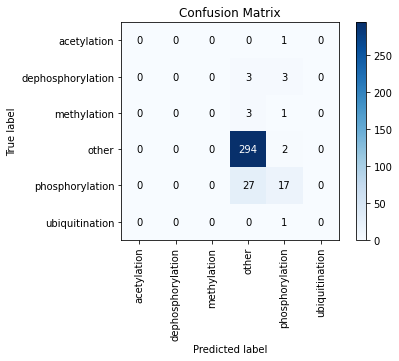

In [7]:
skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=False,x_tick_rotation=90)

In [11]:
df.query("actual != predicted and predicted != 'other'")[["normalised_abstract","participant1Id", "participant2Id","actual", "predicted" ]]

,normalised_abstract,participant1Id,participant2Id,actual,predicted
3,"Q9H0H5, a Rho GAP essential to cytokinesis, wo...",Q9H0H5,P06493,dephosphorylation,phosphorylation
5,The Ebola virus (EBOV) VP35 protein antagonize...,Q14653,Q14164,methylation,phosphorylation
22,Protein tyrosine phosphatases (PTPs) play key ...,P23467,P10912,dephosphorylation,phosphorylation
29,Mice lacking the protein-tyrosine phosphatase ...,O60674,P18031,ubiquitination,phosphorylation
36,Regulation of growth factor dependent cell sur...,P12931,Q06124,dephosphorylation,phosphorylation
45,"Q9H0H5, a Rho GAP essential to cytokinesis, wo...",P06493,Q02241,acetylation,phosphorylation
344,NaN,NaN,NaN,other,phosphorylation
350,NaN,NaN,NaN,other,phosphorylation
